<a href="https://colab.research.google.com/github/dave20874/Lift-Accel/blob/master/Arm-Accel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math

class AccelSubsystem:
  MIN_X_IN = 0.0
  MAX_X_IN = 38.0
  MAX_V_IPS = 40.0
  ACCEL_IPS2 = 60.0
  DELTA_T = 0.02
  MIN_VEL_IPS = 1.0
  MIN_X_IN = 1.0

  def __init__(self):
    self.x_in = 0.0
    self.v_ips = 0.0
    self.desired_x_in = 0.0

  def setState(self, x_in=0.0, v_ips=0.0):
    self.x_in = x_in
    self.v_ips = v_ips

  def getState(self):
    return (self.x_in, self.v_ips, self.moving)

  def moveTo(self, x_in):
    self.desired_x_in = x_in
    self.moving = True

  def periodic(self):
    # distance to target
    delta_x = self.desired_x_in - self.x_in
    v = self.v_ips

    # Simplify all the math by assuming we are moving left to right.
    # If that's not the case, we'll switch delta_x and fix it afterward.
    invert = False

    if delta_x < 0.0:
      # switch direction
      invert = True
      delta_x = -delta_x
      v = -v

    t = math.sqrt(2.0*delta_x / self.ACCEL_IPS2)  # time to cover distance, from stop, at max accel
    speed_limit = self.ACCEL_IPS2 * (t - self.DELTA_T)       # can't go faster than this in this distance
    if speed_limit > self.MAX_V_IPS:
      speed_limit = self.MAX_V_IPS

    if (v >= speed_limit):
        # Must decel
        v -= self.ACCEL_IPS2*self.DELTA_T
        # print("decel")
    elif (v + self.ACCEL_IPS2*self.DELTA_T < speed_limit):
        # May Accel
        v += self.ACCEL_IPS2*self.DELTA_T
        # print("Accel")
    else:
        # Maintain current speed
        v = v
        # print("Maintain")

    # How far we'll move in this step.
    dx = v*self.DELTA_T

    # Un-invert things
    if invert:
      self.x_in += -dx
      self.v_ips = -v
    else:
      self.x_in += dx
      self.v_ips = v

    # Check for end condition
    new_delta_x = self.desired_x_in - self.x_in
    if (abs(self.v_ips) < self.MIN_VEL_IPS) & (abs(new_delta_x) < self.MIN_X_IN):
      # Jump to desired position, zero velocity
      self.x_in = self.desired_x_in
      self.v_ips = 0.0
      self.moving = False;


    






In [30]:
class AccelTest:
    DELTA_T = 0.02 # 20ms period
    
    def __init__(self):
        self.subsystem = AccelSubsystem()
        
    def run(self):
        samples = []
        t = 0.0
        d, v, moving = self.subsystem.getState()
        samples.append([t, v, d])
        # print("t:{:0.2f} d:{:5.2f} v:{:5.2f}".format(t, d, v))        
        
        while (moving & (t < 10.0)):
            self.subsystem.periodic()
            t += AccelTest.DELTA_T
            d, v, moving = self.subsystem.getState()
            samples.append([t, v, d])
            # print("t:{:0.2f} d:{:5.2f} v:{:5.2f}".format(t, d, v))   
            
        return samples
    
    def testZeroToMax(self):
        self.subsystem.setState(AccelSubsystem.MIN_X_IN)
        self.subsystem.moveTo(AccelSubsystem.MAX_X_IN)
        return self.run()

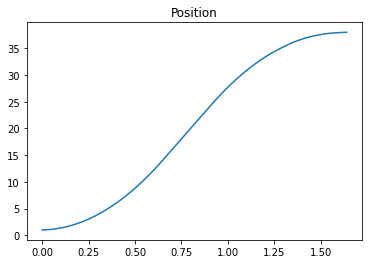

In [34]:
tester = AccelTest()

results = tester.testZeroToMax()
t = [x[0] for x in results]
x = [x[2] for x in results]

plt.plot(t, x)
plt.title('Position')
plt.show()